In [1]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalize(img):
    return (img - np.min(img))/(np.max(img)- np.min(img))*255

In [3]:
class DistanceCluster:
    def __init__(self, img) -> None:
        m, n, _ = img.shape
        self.D = np.zeros((m, n))
        self.L = -np.ones((m, n))
        self.D[:, :] = np.inf


In [4]:
class Superpixels(DistanceCluster):
    def __init__(self, img, n_sp, threshold=0.5, C=10) -> None:
        super().__init__(img)
        self.img = img
        n_tp = self.img.shape[0] * self.img.shape[1]  # * img.shape[2]
        self.s = int((n_tp / n_sp) ** 0.5)
        # self.DL = DistanceCluster(self.img)
        self.threshold = threshold
        self.c = C

    # Step 1
    def _calculate_gradient(self, image, x1, y1, x2, y2):
        # Get the RGB values of the two pixels
        pixel1 = image[y1, x1]
        pixel2 = image[y2, x2]

        # Calculate the gradient as the sum of absolute differences of RGB values
        gradient = np.sum(np.abs(pixel1 - pixel2))

        return gradient
        
    def _calculate_lowest_gradient_position(self, image, x, y):
        # Get the dimensions of the image
        height, width, _ = image.shape

        # Define the boundaries for the 3x3 neighborhood
        x_start = max(x - 1, 0)
        x_end = min(x + 1, width - 1)
        y_start = max(y - 1, 0)
        y_end = min(y + 1, height - 1)

        # Initialize variables to store the lowest gradient position
        min_gradient = float("inf")
        min_x = x
        min_y = y

        # Iterate over the 3x3 neighborhood
        for i in range(y_start, y_end + 1):
            for j in range(x_start, x_end + 1):
                # Calculate the gradient at the current position
                gradient = self._calculate_gradient(image, x, y, j, i)
                # Update the lowest gradient position if necessary
                if gradient < min_gradient:
                    min_gradient = gradient
                    min_x = j
                    min_y = i
        return min_x, min_y



    def _initialize_algo(self):
        # The function creates the centers list
        m_list = []
        # finding the pixels with s distance
        x = [l % self.img.shape[0] for l in range(self.s, self.img.shape[0], self.s)]
        y = [l % self.img.shape[1] for l in range(self.s, self.img.shape[1], self.s)]
        for i in range(len(x)):
            for j in range(len(y)):
                x1, y1 = self._calculate_lowest_gradient_position(self.img, x[i], y[j])
                r, g, b = self.img[x1, y1, :3]
                m_list.append(np.array([r, g, b, x1, y1]).T)
        return m_list

    # Step 2
    def _calculate_distance(self, v1, v2):
        dc_squared = np.sum((v1[:3] - v2[:, :, :3]) ** 2, axis=2)
        ds_squared = np.sum((v1[3:] - v2[:, :, 3:]) ** 2, axis=2)
        return np.sqrt((dc_squared / self.c) ** 2 + (ds_squared / self.s) ** 2)

    def _set_neigbors_dist(self, mi, cluster):
        x_start = max(0, int(mi[3] - 2 * self.s))
        y_start = max(0, int(mi[4] - 2 * self.s))
        x_stop = min(int(mi[3] + 2 * self.s), self.img.shape[0])
        y_stop = min(int(mi[4] + 2 * self.s), self.img.shape[1])

        v = np.empty((x_stop - x_start, y_stop - y_start, 5))
        v[:, :, :3] = self.img[x_start:x_stop, y_start:y_stop, :3]
        v[:, :, 3:] = np.indices((x_stop - x_start, y_stop - y_start)).transpose(
            1, 2, 0
        ) + [x_start, y_start]

        d = self._calculate_distance(mi, v)
        mask = d < self.D[x_start:x_stop, y_start:y_stop]
        self.D[x_start:x_stop, y_start:y_stop] = np.where(
            mask, d, self.D[x_start:x_stop, y_start:y_stop]
        )
        self.L[x_start:x_stop, y_start:y_stop] = np.where(
            mask, cluster, self.L[x_start:x_stop, y_start:y_stop]
        )

    def _assign_clusters(self):
        for i, v in enumerate(self.m_i):
            self._set_neigbors_dist(v, i)

    # Step 3
    def _find_cluster_coordinates(self, CLUSTER):
        # Find the indices where the matrix equals the CLUSTER value
        indices = np.argwhere(self.L == CLUSTER)

        # Extract the x, y coordinates from the indices
        coordinates = [(index[0], index[1]) for index in indices]

        return coordinates

    def _update_mi(self):
        test_convergence = []
        relevant_clusters = np.unique(self.L)
        for cluster in relevant_clusters:
            coordinates = self._find_cluster_coordinates(cluster)
            c_i = len(coordinates)
            coordinates = np.array(coordinates)
            t = np.zeros(5)
            t[:3] = np.sum(self.img[coordinates[:, 0], coordinates[:, 1], :3], axis=0)
            t[3:] = np.sum(coordinates, axis=0)
            t /= c_i
            cluster = int(cluster)
            test_convergence.append(np.linalg.norm(self.m_i[cluster] - t))
            self.m_i[cluster] = t
        self.test_convergence = np.array(test_convergence)

    def paint_clusters(self):
        unique_clusters = np.unique(self.L)
        colors = np.zeros((unique_clusters.shape[0], 3))

        for i, cluster in enumerate(unique_clusters):
            coordinates = np.array(self._find_cluster_coordinates(cluster))
            cluster_colors = self.img[coordinates[:, 0], coordinates[:, 1], :3]
            average_color = np.mean(cluster_colors, axis=0)
            colors[i] = average_color

            for coord in coordinates:
                self.img[coord[0], coord[1], :3] = average_color

        plt.imshow(self.img)
        plt.show()

    def __call__(self):
        self.m_i = self._initialize_algo()
        self._assign_clusters()
        self._update_mi()
        # while np.sum(self.test_convergence) > self.threshold:
        #     print(np.sum(sup.test_convergence))
        #     self._assign_clusters()
        #     self._update_mi()

In [7]:
img = imread("IMG_6961.jpg")
# img = imread("totem.png")
img= np.uint8(normalize(img))
sup = Superpixels(img, 100)
sup()

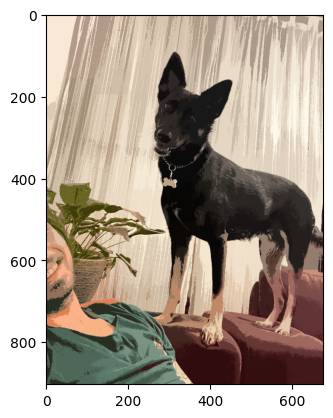

In [8]:
sup.paint_clusters()